In [1]:
%%capture
from __future__ import division
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="size changed")

import sys 
is_py2 = sys.version[0] == '2'
if is_py2:
    import Queue as queue
else:
    import queue as queue

from collections import defaultdict
from termcolor import colored, cprint
import tensorflow as tf
import numpy as np
import threading
import random
import os
import time
import math
import h5py
import json

import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

from config import config, loadDatasetConfig, parseArgs
from preprocess import Preprocesser, bold, bcolored, writeline, writelist
from model import MACnet

data_location = './data/'

In [2]:
############################################# loggers #############################################

# Writes log header to file 
def logInit():
    with open(config.logFile(), "a+") as outFile:
        writeline(outFile, config.expName)
        headers = ["epoch", "trainAcc", "valAcc", "trainLoss", "valLoss"]
        if config.evalTrain:
            headers += ["evalTrainAcc", "evalTrainLoss"]
        if config.extra:
            if config.evalTrain:
                headers += ["thAcc", "thLoss"]
            headers += ["vhAcc", "vhLoss"]
        headers += ["time", "lr"]

        writelist(outFile, headers)
        # lr assumed to be last

# Writes log record to file 
def logRecord(epoch, epochTime, lr, trainRes, evalRes, extraEvalRes):
    with open(config.logFile(), "a+") as outFile:
        record = [epoch, trainRes["acc"], evalRes["val"]["acc"], trainRes["loss"], evalRes["val"]["loss"]]
        if config.evalTrain:
            record += [evalRes["train"]["acc"], evalRes["train"]["loss"]]
        if config.extra:
            if config.evalTrain:
                record += [extraEvalRes["train"]["acc"], extraEvalRes["train"]["loss"]]
            record += [extraEvalRes["val"]["acc"], extraEvalRes["val"]["loss"]]
        record += [epochTime, lr]

        writelist(outFile, record)

# Gets last logged epoch and learning rate
def lastLoggedEpoch():
    with open(config.logFile(), "r") as inFile:
        lastLine = list(inFile)[-1].split(",") 
    epoch = int(lastLine[0])
    lr = float(lastLine[-1])   
    return epoch, lr 

################################## printing, output and analysis ##################################

# Analysis by type
analysisQuestionLims = [(0,18),(19,float("inf"))]
analysisProgramLims = [(0,12),(13,float("inf"))]

toArity = lambda instance: instance["programSeq"][-1].split("_", 1)[0]
toType = lambda instance: "boolean" if (instance["answer"] in ["yes", "no"]) else "open"
toQType = lambda instance: instance["questionType"]
toAType = lambda instance: instance["answerType"]

def fieldLenIsInRange(field):
    return lambda instance, group: \
        (len(instance[field]) >= group[0] and
        len(instance[field]) <= group[1])

# Groups instances based on a key
def grouperKey(toKey):
    def grouper(instances):
        res = defaultdict(list)
        for instance in instances:
            res[toKey(instance)].append(instance)
        return res
    return grouper

# Groups instances according to their match to condition
def grouperCond(groups, isIn):
    def grouper(instances):
        res = {}
        for group in groups:
            res[group] = (instance for instance in instances if isIn(instance, group))
        return res
    return grouper 

groupers = {
    "questionLength": grouperCond(analysisQuestionLims, fieldLenIsInRange("question")),
    "programLength": grouperCond(analysisProgramLims, fieldLenIsInRange("programSeq")),
    "arity": grouperKey(toArity),
    "type": grouperKey(toType),
    "qType": grouperKey(toQType),
    "aType": grouperKey(toAType)
}

# Computes average
def avg(instances, field):
    if len(instances) == 0:
        return 0.0
    return sum([(1 if instance["prediction"] == instance["answer"] else 0) for instance in instances]) / len(instances)

# Prints analysis of questions loss and accuracy by their group 
def printAnalysis(res):
    if config.analysisType != "":
        print("Analysis by {type}".format(type = config.analysisType))
        groups = groupers[config.analysisType](res["preds"])
        for key in groups:
            instances = groups[key]
            # avgLoss = avg(instances, "loss") avgLoss
            avgAcc = avg(instances, "acc")
            num = len(instances)
            print("Group {key}: Loss: {loss}, Acc: {acc}, Num: {num}".format(key = key, loss = 0, acc = avgAcc, num = num))

# Print results for a tier
def printTierResults(tierName, res, color):
    if res is None:
        return

    print("{tierName} Loss: {loss}, {tierName} accuracy: {acc}, minLoss: {minLoss}, maxAcc: {maxAcc}".format(tierName = tierName,
        loss = bcolored(res["loss"], color), 
        acc = bcolored(res["acc"], color),
        minLoss = bcolored(res["minLoss"], color),
        maxAcc = bcolored(res["maxAcc"], color)))
    
    printAnalysis(res)

# Prints dataset results (for several tiers)
def printDatasetResults(trainRes, evalRes, extraEvalRes):
    printTierResults("Training", trainRes, "magenta")
    printTierResults("Training EMA", evalRes["train"], "red")
    printTierResults("Validation", evalRes["val"], "cyan")
    printTierResults("Extra Training EMA", extraEvalRes["train"], "red")
    printTierResults("Extra Validation", extraEvalRes["val"], "cyan")    

# Writes predictions for several tiers
def writePreds(preprocessor, evalRes, extraEvalRes):
    preprocessor.writePreds(evalRes["train"], "train")
    preprocessor.writePreds(evalRes["val"], "val")
    preprocessor.writePreds(evalRes["test"], "test")
    preprocessor.writePreds(extraEvalRes["train"], "train", "H")
    preprocessor.writePreds(extraEvalRes["val"], "val", "H")
    preprocessor.writePreds(extraEvalRes["test"], "test", "H")

def inp(msg):
    if sys.version_info[0] < 3:
        return raw_input(msg)
    else:
        return input(msg)

############################################# session #############################################
# Initializes TF session. Sets GPU memory configuration.
def setSession():
    sessionConfig = tf.ConfigProto(allow_soft_placement = True, log_device_placement = False)
    if config.allowGrowth:
        sessionConfig.gpu_options.allow_growth = True
    if config.maxMemory < 1.0:
        sessionConfig.gpu_options.per_process_gpu_memory_fraction = config.maxMemory
    return sessionConfig

############################################## savers #############################################
# Initializes savers (standard, optional exponential-moving-average and optional for subset of variables)
def setSavers(model):
    saver = tf.train.Saver(max_to_keep = config.weightsToKeep)

    subsetSaver = None
    if config.saveSubset:
        isRelevant = lambda var: any(s in var.name for s in config.varSubset)
        relevantVars = [var for var in tf.global_variables() if isRelevant(var)]
        subsetSaver = tf.train.Saver(relevantVars, max_to_keep = config.weightsToKeep, allow_empty = True)
    
    emaSaver = None
    if config.useEMA: 
        emaSaver = tf.train.Saver(model.emaDict, max_to_keep = config.weightsToKeep)

    return {
        "saver": saver,
        "subsetSaver": subsetSaver,
        "emaSaver": emaSaver
    }

################################### restore / initialize weights ##################################
# Restores weights of specified / last epoch if on restore mod.
# Otherwise, initializes weights.  
def loadWeights(sess, saver, init):
    if config.restoreEpoch > 0 or config.restore:
        # restore last epoch only if restoreEpoch isn't set
        if config.restoreEpoch == 0:
            # restore last logged epoch
            config.restoreEpoch, config.lr = lastLoggedEpoch()
        #print(bcolored("Restoring epoch {} and lr {}".format(config.restoreEpoch, config.lr),"cyan"))
        #print(bcolored("Restoring weights", "blue"))
        saver.restore(sess, config.weightsFile(config.restoreEpoch))
        epoch = config.restoreEpoch
    else:
        print(bcolored("Initializing weights", "blue"))
        sess.run(init)
        logInit()
        epoch = 0

    return epoch 

###################################### training / evaluation ######################################
# Chooses data to train on (main / extra) data. 
def chooseTrainingData(data):
    trainingData = data["main"]["train"]
    alterData = None

    if config.extra:
        if config.trainExtra:
            if config.extraVal:
                trainingData = data["extra"]["val"]
            else:
                trainingData = data["extra"]["train"]                  
        if config.alterExtra:
            alterData = data["extra"]["train"]

    return trainingData, alterData

#### evaluation
# Runs evaluation on train / val / test datasets.
def runEvaluation(sess, model, data, dataOps, epoch, evalTrain = True, evalTest = False, 
    getPreds = False, getAtt = None, prevRes = None):
    if getAtt is None:
        getAtt = config.getAtt
    res = {"train": None, "val": None, "test": None}
    
    if data is not None:
        if evalTrain and config.evalTrain:
            res["train"] = runEpoch(sess, model, data["evalTrain"], dataOps, train = False, epoch = epoch, getPreds = getPreds, getAtt = getAtt, 
                maxAcc = prevRes["train"]["maxAcc"] if prevRes else 0.0,
                minLoss = prevRes["train"]["minLoss"] if prevRes else float("inf"))

        res["val"] = runEpoch(sess, model, data["val"], dataOps, train = False, epoch = epoch, getPreds = getPreds, getAtt = getAtt, 
            maxAcc = prevRes["val"]["maxAcc"] if prevRes else 0.0,
            minLoss = prevRes["val"]["minLoss"] if prevRes else float("inf"))
        
        if evalTest or config.test:
            res["test"] = runEpoch(sess, model, data["test"], dataOps, train = False, epoch = epoch, getPreds = getPreds, getAtt = getAtt, 
                maxAcc = prevRes["test"]["maxAcc"] if prevRes else 0.0,
                minLoss = prevRes["test"]["minLoss"] if prevRes else float("inf"))    
        
    return res

## training conditions (comparing current epoch result to prior ones)
def improveEnough(curr, prior, lr):
    prevRes = prior["prev"]["res"]
    currRes = curr["res"]

    if prevRes is None:
        return True

    prevTrainLoss = prevRes["train"]["loss"]
    currTrainLoss = currRes["train"]["loss"]
    lossDiff = prevTrainLoss - currTrainLoss
    
    ## FOR CLEVR
    if config.dataset == "CLEVR":
        notImprove = ((lossDiff < 0.015 and prevTrainLoss < 0.5 and lr > 0.00002) or \
                      (lossDiff < 0.008 and prevTrainLoss < 0.15 and lr > 0.00001) or \
                      (lossDiff < 0.003 and prevTrainLoss < 0.10 and lr > 0.000005))
                      #(prevTrainLoss < 0.2 and config.lr > 0.000015)
    else:
        notImprove = (lossDiff < 0.02 and lr > 0.00005)
                      #(prevTrainLoss < 0.2 and config.lr > 0.000015)

    return not notImprove

def better(currRes, bestRes):
    return currRes["val"]["acc"] > bestRes["val"]["acc"]

############################################## data ###############################################
#### instances and batching 
# Trims sequences based on their max length.
def trim2DVectors(vectors, vectorsLengths):
    maxLength = np.max(vectorsLengths)
    return vectors[:,:maxLength]

# Trims batch based on question length.
def trimData(data):
    data["questions"] = trim2DVectors(data["questions"], data["questionLengths"])
    return data

# Gets batch / bucket size.
def getLength(data):
    return len(data["indices"]) # len(data["instances"])

# Selects the data entries that match the indices. 
def selectIndices(data, indices):
    def select(field, indices): 
        if type(field) is np.ndarray:
            return field[indices]
        if type(field) is list:
            return [field[i] for i in indices]
        else:
            return field
    selected = {k : select(d, indices) for k,d in data.items()}
    return selected

# Batches data into a a list of batches of batchSize. 
# Shuffles the data by default.
def getBatches(data, batchSize = None, shuffle = True):
    batches = []

    dataLen = getLength(data)
    if batchSize is None or batchSize > dataLen:
        batchSize = dataLen
    
    indices = np.arange(dataLen)
    if shuffle:
        np.random.shuffle(indices)

    for batchStart in range(0, dataLen, batchSize):
        batchIndices = indices[batchStart : batchStart + batchSize]
        # if len(batchIndices) == batchSize?
        if len(batchIndices) >= config.gpusNum:
            batch = selectIndices(data, batchIndices)
            batches.append(batch)
            # batchesIndices.append((data, batchIndices))

    return batches

#### image batches
# Opens image files.
def openImageFiles(images):
    for group in images:
        images[group]["imagesFile"] = h5py.File(images[group]["imagesFilename"], "r")
        if config.dataset != "CLEVR":
            with open(images[group]["imgsInfoFilename"], "r") as file:
                images[group]["imgsInfo"] = json.load(file) 

# Closes image files.
def closeImageFiles(images): 
    for group in images:
        images[group]["imagesFile"].close()

# Loads an images from file for a given data batch.
def loadImageBatch(images, batch):
    imagesGroup = lambda imageId: images[imageId["group"]]
    toFile = lambda imageId: imagesGroup(imageId)["imagesFile"]
    toInfo = lambda imageId: imagesGroup(imageId)["imgsInfo"][str(imageId["id"])]

    if config.imageObjects:
        imageBatch = np.zeros((len(batch["imageIds"]), config.imageDims[0], config.imageDims[1]))
        for i, imageId in enumerate(batch["imageIds"]):
            numObjects = toInfo(imageId)["objectsNum"]

            imageBatch[i, 0:numObjects] = toFile(imageId)["features"][imageId["idx"], 0:numObjects]

    else:
        imageBatch = np.stack([toFile(imageId)["features"][imageId["idx"]]     
            for imageId in batch["imageIds"]], axis = 0)

        config.imageDims = imageBatch.shape[1:]
    
    ret = {"images": imageBatch, "imageIds": batch["imageIds"]}
    
    return ret 

# Loads images for several num batches in the batches list from start index. 
def loadImageBatches(images, batches, start, num):
    batches = batches[start: start + num]
    return [loadImageBatch(images, batch) for batch in batches]

#### data alternation
# Alternates main training batches with extra data.
def alternateData(batches, alterData, dataLen):
    alterData = alterData["data"][0] # data isn't bucketed for altered data

    # computes number of repetitions
    needed = math.ceil(len(batches) / config.alterNum) 
    print(bold("Extra batches needed: %d") % needed)
    perData = math.ceil(getLength(alterData) / config.batchSize)
    print(bold("Batches per extra data: %d") % perData)
    repetitions = math.ceil(needed / perData)
    print(bold("reps: %d") % repetitions)
    
    # make alternate batches
    alterBatches = []
    for _ in range(repetitions):
        repBatches = getBatches(alterData, batchSize = config.batchSize)
        random.shuffle(repBatches)
        alterBatches += repBatches
    print(bold("Batches num: %d") + len(alterBatches))
    
    # alternate data with extra data
    curr = len(batches) - 1
    for alterBatch in alterBatches:
        if curr < 0:
            break
        batches.insert(curr, alterBatch)
        dataLen += getLength(alterBatch)
        curr -= config.alterNum

    return batches, dataLen

############################################ threading ############################################

imagesQueue = queue.Queue(maxsize = 20) # config.tasksNum
inQueue = queue.Queue(maxsize = 1)
outQueue = queue.Queue(maxsize = 1)

def loaderRun(images, batches):
    batchNum = 0

    while batchNum < len(batches):
        nextItem = loadImageBatches(images, batches, batchNum, config.taskSize)
        assert len(nextItem) == min(config.taskSize, len(batches) - batchNum)
        batchNum += config.taskSize                    
        imagesQueue.put(nextItem)

########################################## stats tracking #########################################
# Computes exponential moving average.
def emaAvg(avg, value):
    if avg is None:
        return value
    emaRate = 0.98
    return avg * emaRate + value * (1 - emaRate)

# Initializes training statistics.
def initStats():
    return {
        "totalBatches": 0,
        "totalData": 0,
        "totalLoss": 0.0,
        "totalCorrect": 0,
        "totalAcc": 0.0,
        "loss": 0.0,
        "acc": 0.0,
        "emaLoss": None,
        "emaAcc": None,
    }

# Updates statistics with training results of a batch
def updateStats(stats, res): 
    stats["totalBatches"] += 1
    stats["totalData"] += res["batchSize"]

    stats["totalLoss"] += res["loss"]
    stats["totalCorrect"] += res["correctNum"]
    stats["totalAcc"] += res["acc"]

    stats["loss"] = stats["totalLoss"] / stats["totalBatches"]
    stats["acc"] = stats["totalCorrect"] / stats["totalData"]
    
    stats["emaLoss"] = emaAvg(stats["emaLoss"], res["loss"])
    stats["emaAcc"] = emaAvg(stats["emaAcc"], res["acc"])

    return stats 

# Translates training statistics into a string to print
def statsToStr(stats, res, epoch, batchNum, dataLen, startTime):
    formatStr = "\reb {epoch},{batchNum} ({dataProcessed} / {dataLen:5d}), " + \
                             "t = {time} ({loadTime:2.2f}+{trainTime:2.2f}), " + \
                             "lr {lr}, l = {loss}, a = {acc}, avL = {avgLoss}, " + \
                             "avA = {avgAcc}, g = {gradNorm:2.4f}, " + \
                             "emL = {emaLoss:2.4f}, emA = {emaAcc:2.4f}; " + \
                             "{expname}"

    s_epoch = bcolored("{:2d}".format(epoch),"green")
    s_batchNum = "{:3d}".format(batchNum)
    s_dataProcessed = bcolored("{:5d}".format(stats["totalData"]),"green")
    s_dataLen = dataLen
    s_time = bcolored("{:2.2f}".format(time.time() - startTime),"green")
    s_loadTime = res["readTime"] 
    s_trainTime = res["trainTime"]
    s_lr = bold(config.lr)
    s_loss = bcolored("{:2.4f}".format(res["loss"]), "blue")
    s_acc = bcolored("{:2.4f}".format(res["acc"]),"blue")
    s_avgLoss = bcolored("{:2.4f}".format(stats["loss"]), "blue")
    s_avgAcc = bcolored("{:2.4f}".format(stats["acc"]),"red")
    s_gradNorm = res["gradNorm"]  
    s_emaLoss = stats["emaLoss"]
    s_emaAcc = stats["emaAcc"]
    s_expname = config.expName 

    return formatStr.format(epoch = s_epoch, batchNum = s_batchNum, dataProcessed = s_dataProcessed,
                            dataLen = s_dataLen, time = s_time, loadTime = s_loadTime,
                            trainTime = s_trainTime, lr = s_lr, loss = s_loss, acc = s_acc,
                            avgLoss = s_avgLoss, avgAcc = s_avgAcc, gradNorm = s_gradNorm,
                            emaLoss = s_emaLoss, emaAcc = s_emaAcc, expname = s_expname)

'''
Runs an epoch with model and session over the data.
1. Batches the data and optionally mix it with the extra alterData.
2. Start worker threads to load images in parallel to training.
3. Runs model for each batch, and gets results (e.g. loss,  accuracy).
4. Updates and prints statistics based on batch results.
5. Once in a while (every config.saveEvery), save weights. 

Args:
    sess: TF session to run with.
    
    model: model to process data. Has runBatch method that process a given batch.
    (See model.py for further details).
    
    data: data to use for training/evaluation.
    
    epoch: epoch number.

    saver: TF saver to save weights

    calle: a method to call every number of iterations (config.calleEvery)

    alterData: extra data to mix with main data while training.

    getAtt: True to return model attentions.  
'''    
def runEpoch(sess, model, data, dataOps, train, epoch, saver = None, calle = None, 
    alterData = None, getPreds = False, getAtt = False, maxAcc = 0.0, minLoss = float("Inf")):
    dataLen = sum(getLength(bucket) for bucket in data["data"])
    if dataLen == 0:
        return {"loss": 0, 
            "acc": 0,
            "maxAcc": 0,
            "minLoss": 0,
            "preds": []
            }

    # initialization
    startTime0 = time.time()

    stats = initStats()
    preds = []

    # open image files
    openImageFiles(data["images"])

    ## prepare batches
    buckets = data["data"]
    dataLen = sum(getLength(bucket) for bucket in buckets)
    
    # make batches and randomize
    batches = []
    for bucket in buckets:
        batches += getBatches(bucket, batchSize = config.batchSize)
    random.shuffle(batches)

    # alternate with extra data
    if train and alterData is not None:
        batches, dataLen = alternateData(batches, alterData, dataLen)

    # for batchNum, batch in enumerate(batches):  
    batchNum = 0
    batchesNum = len(batches) 

    while batchNum < batchesNum:
        try:
            startTime = time.time()

            # prepare batch 
            batch = batches[batchNum]
            batch = trimData(batch)

            # load images batch
            imagesBatch = loadImageBatch(data["images"], batch)
            for i, imageId in enumerate(batch["imageIds"]):
                assert imageId == imagesBatch["imageIds"][i]   
            
            # run batch
            res = model.runBatch(sess, batch, imagesBatch, train, getPreds, getAtt)

            # update stats
            stats = updateStats(stats, res) # , batch
            preds += res["preds"]

            sys.stdout.write(statsToStr(stats, res, epoch, batchNum, dataLen, startTime))
            sys.stdout.flush()

            # save weights
            if saver is not None:
                if batchNum > 0 and batchNum % config.saveEvery == 0:
                    print("")
                    print(bold("saving weights"))
                    saver.save(sess, config.weightsFile(epoch))

            # calle
            if calle is not None:            
                if batchNum > 0 and batchNum % config.calleEvery == 0:
                    calle()

            batchNum += 1

        except tf.errors.OutOfRangeError:
            break

    sys.stdout.write("\r")
    sys.stdout.flush()

    closeImageFiles(data["images"])

    return {"loss": stats["loss"], 
            "acc": stats["acc"],
            "maxAcc": max(stats["acc"], maxAcc),
            "minLoss": min(stats["loss"], minLoss),
            "preds": preds
            }

In [3]:
%%capture
parseArgs()

SystemExit: 2

In [4]:
config.expName = 'gqaSmall'
#config.finalTest = True
#config.test = True
config.interactive = True
config.getPreds = False
config.netLength = 4
config.restore = True
config.testedNum = 5
config.getAtt = True

In [5]:
config.dataset = 'GQA'
config.dataSubset='balanced'
config.featureType = 'gqa_objects'
config.imageObjects = True
config.stemNormalize = True
config.lossType='sigmoid'
config.npy = True
config.parallel = True
config.evalTrain = True
config.retainVal = True
config.useEMA = True
config.noBucket = True
config.adam = True
config.lrReduce = True
config.clipGradients = True
config.relu = 'ELU'
config.encBi = True
config.initCtrl = 'Q'
config.controlContextual = True
config.controlInputUnshared = True
config.readProjInputs = True
config.readMemConcatKB = True
config.readMemConcatProj = True
config.readMemProj = True
config.readCtrl = True
config.writeMemProj = True
config.memoryVariationalDropout = True
config.outQuestion = True
config.outQuestionMul = True

In [6]:
# Preprocess and Load model

loadDatasetConfig["GQA"]() 
with open(config.configFile(), "a+") as outFile:
    json.dump(vars(config), outFile)

# set gpus
if config.gpus != "":
    config.gpusNum = len(config.gpus.split(","))
    os.environ["CUDA_VISIBLE_DEVICES"] = config.gpus

tf.logging.set_verbosity(tf.logging.ERROR)

# process data
print(bold("Preprocess data..."))
start = time.time()
preprocessor = Preprocesser()
data, embeddings, answerDict, questionDict = preprocessor.preprocessData()
print("took {} seconds".format(bcolored("{:.2f}".format(time.time() - start), "blue")))

nextElement = None
dataOps = None

# build model
print(bold("Building model..."))
start = time.time()
model = MACnet(embeddings, answerDict, questionDict, nextElement)
print("took {} seconds".format(bcolored("{:.2f}".format(time.time() - start), "blue")))

# initializer
init = tf.global_variables_initializer()

# savers
savers = setSavers(model)
saver, emaSaver = savers["saver"], savers["emaSaver"]

# sessionConfig
sessionConfig = setSession()

Preprocess data...
load dictionaries
Loading data...
Reading tier train
Reading tier val
Reading tier testdev
took 16.53 seconds
Loading word vectors...
loaded embs from file
took 0.01 seconds
Vectorizing data...
took 4.87 seconds
answerWordsNum
1845
took 23.15 seconds
Building model...
took 4.96 seconds


In [7]:
'''
Trains/evaluates the model:
1. Set GPU configurations.
2. Preprocess data: reads from datasets, and convert into numpy arrays.
3. Builds the TF computational graph for the MAC model.
4. Starts a session and initialize / restores weights.
5. If config.train is True, trains the model for number of epochs:
    a. Trains the model on training data
    b. Evaluates the model on training / validation data, optionally with 
       exponential-moving-average weights.
    c. Prints and logs statistics, and optionally saves model predictions.
    d. Optionally reduces learning rate if losses / accuracies don't improve,
       and applies early stopping.
6. If config.test is True, runs a final evaluation on the dataset and print
   final results!
'''


def VQA_main():

    with tf.Session(config = sessionConfig) as sess:

        # ensure no more ops are added after model is built
        sess.graph.finalize()

        # restore / initialize weights, initialize epoch variable
        epoch = loadWeights(sess, saver, init)

        trainRes, evalRes = None, None

        if config.interactive:
            if epoch > 0:
                if config.useEMA:
                    emaSaver.restore(sess, config.weightsFile(epoch))
                else:
                    saver.restore(sess, config.weightsFile(epoch))

            tier = config.interactiveTier
            images = data["main"][tier]["images"]

            imgsInfoFilename = config.imgsInfoFile(tier)
            with open(imgsInfoFilename, "r") as file:
                imageIndex = json.load(file)  

            openImageFiles(images)

            resInter = {"preds": []}

            for j_str in ['2404342','2366550','2367240', '2362999', '2409147', '2319456', '2342134', '2341361']:

                imageId = j_str
                plt.figure(figsize=(10,6))
                img_ex = cv2.imread(data_location + 'images/' + imageId + '.jpg')
                img_ex = cv2.cvtColor(img_ex, cv2.COLOR_BGR2RGB)
                plt.imshow(img_ex)
                plt.show()
                
                
                text = inp("Enter question:\n ")
                if len(text) == 0:
                    break
                questionStr = text

                imageInfo = imageIndex[imageId]

                imageId = {"group": tier, "id": imageId, "idx": imageInfo["index"]} 
                question = preprocessor.encodeQuestionStr(questionStr)
                instance = {
                    "questionStr": questionStr,
                    "question": question,
                    "answer": "yes", 
                    "answerFreq": ["yes"], 
                    "imageId": imageId,
                    "tier": tier,
                    "index": 0 
                }

                if config.imageObjects:
                    instance["objectsNum"] = imageInfo["objectsNum"]

                print(instance)
                
                datum = preprocessor.vectorizeData([instance])
                
                print('\ndatum:', datum)
                image = loadImageBatch(images, {"imageIds": [imageId]})
                res = model.runBatch(sess, datum, image, train = False, getPreds = True, getAtt = True)
                resInter["preds"].append(instance)

                print('\nPrediction:', instance["prediction"])

            if config.getPreds:
                print(bcolored("Writing predictions...", "gray"))
                preprocessor.writePreds(resInter, "interactive".format())

            closeImageFiles(images)

        print(bcolored("Done!","white"))



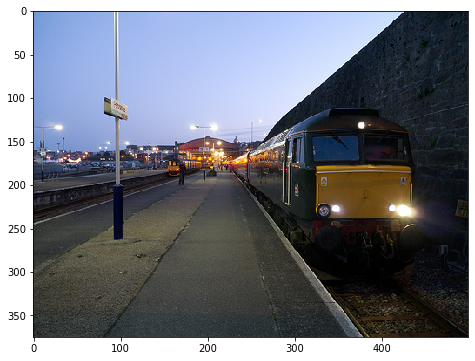

Enter question:
 what is the weather
{'questionStr': 'what is the weather', 'question': ['what', 'is', 'weather'], 'answer': 'yes', 'answerFreq': ['yes'], 'imageId': {'group': 'val', 'id': '2404342', 'idx': 79680}, 'tier': 'val', 'index': 0, 'objectsNum': 28}

datum: {'questions': array([[45, 18, 69]]), 'questionLengths': array([3]), 'answers': array([5]), 'imageIds': [{'group': 'val', 'id': '2404342', 'idx': 79680}], 'indices': [0], 'instances': [{'questionStr': 'what is the weather', 'question': ['what', 'is', 'weather'], 'answer': 'yes', 'answerFreq': ['yes'], 'imageId': {'group': 'val', 'id': '2404342', 'idx': 79680}, 'tier': 'val', 'index': 0, 'objectsNum': 28}], 'objectsNums': [28]}

Prediction: cloudless


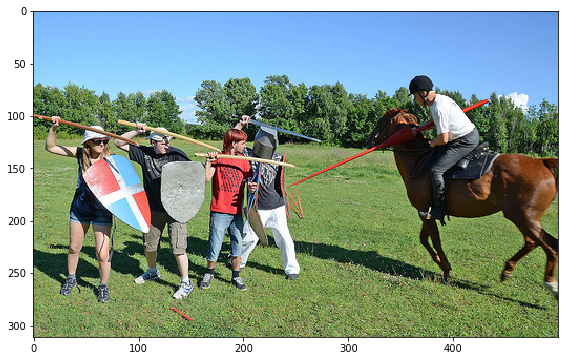

In [ ]:
VQA_main()